In [271]:
pip install pandas tensorflow scikit-learn matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


In [528]:
print(f"TensorFlow Version: {tf.__version__}")

TensorFlow Version: 2.15.0


In [521]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5915365628150640557
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10904207360
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15668836433980213398
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:07:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


2024-02-26 06:12:01.548302: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-26 06:12:01.548590: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-26 06:12:01.548804: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [527]:
import tensorflow.python.platform.build_info as tf_build
print(f"CUDA Version: {tf_build.build_info['cuda_version']}")
print(f"cuDNN Version: {tf_build.build_info['cudnn_version']}")

CUDA Version: 12.2
cuDNN Version: 8


In [532]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


In [533]:
import pandas as pd
# df = pd.read_csv('dataset_cleaned.csv', sep=';')
# df = pd.read_csv('dataset_temp.csv', sep=';')
df = pd.read_csv('dataset_temp_balanced.csv', sep=';')
df['text'] = df['text'].astype(str)
df['sentiment'] = df['sentiment'].astype(str)
print(df['sentiment'].value_counts())
df.head()

sentiment
positive    8622
negative    8622
neutral     8622
Name: count, dtype: int64


,text,sentiment
0,nolan finally created movie care watch,positive
1,become death,negative
2,end trailer would prime opportunity add become...,negative
3,showing japan want see chris movie,positive
4,pov nolan directs movie audience son btc,neutral


In [534]:
from gensim.models import FastText
# fasttext_model = FastText.load('fasttext_model.bin')
# fasttext_model = FastText.load('fasttext_model_2.bin')
# fasttext_model = FastText.load('fasttext_model_3.bin')
fasttext_model = FastText.load('fasttext_model_4.bin')

In [535]:
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(split=' ')
tokenizer.fit_on_texts(df['text'])
list(tokenizer.word_index.items())[:10]

[('movie', 1),
 ('nolan', 2),
 ('bomb', 3),
 ('oppenheimer', 4),
 ('world', 5),
 ('film', 6),
 ('see', 7),
 ('like', 8),
 ('one', 9),
 ('trailer', 10)]

In [536]:
sequences = tokenizer.texts_to_sequences(df['text'])
word_index = tokenizer.word_index

In [537]:
import numpy as np
vocab_size = len(word_index) + 1
embedding_matrix = np.random.random((vocab_size, 32))
for word, i in word_index.items():
    try:
        embedding_vector = fasttext_model.wv[word]
    except:
        print(f'word \"{word}\" is not found')
    if embedding_vector is not None:
        embedding_matrix[i, :] = embedding_vector

In [514]:
print(vocab_size)
print(embedding_matrix)

18461
[[ 0.56239181  0.83772244  0.19948037 ...  0.05221607  0.01088569
   0.07322898]
 [ 1.21923006 -0.90278894  2.84340906 ... -1.59649765  0.65523094
  -6.25575161]
 [-3.30254292 -2.79855061  3.54974651 ...  3.43789935  0.42861193
  -4.13434219]
 ...
 [ 2.28994441 -3.89270377 -2.12757683 ... -4.1187315   1.99107385
   0.12887029]
 [ 0.91570663 -0.84785795 -0.56067395 ... -0.32277721  0.70294482
   0.22199719]
 [-0.33618939 -1.08258367 -0.43594459 ... -0.45747146 -0.48332354
   0.51961732]]


In [538]:
from keras.preprocessing import sequence
MAX_SEQUENCE_LENGTH = 300
data = sequence.pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

In [539]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
SPLIT_RATIO = 0.2
RANDOM_STATE = 27
X = df['text']
y = df['sentiment']
l_encode = LabelEncoder()
l_encode.fit(y)
y = l_encode.transform(y)
y = to_categorical(y, num_classes=3)
X_train_val, X_test, y_train_val, y_test = train_test_split(data, y, test_size=SPLIT_RATIO, random_state=RANDOM_STATE)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=SPLIT_RATIO, random_state=RANDOM_STATE)
print(X_train[:10])
print(y_train[:10])

[[   73  3240    12 ...     0     0     0]
 [11832   164   181 ...     0     0     0]
 [   18    24 16894 ...     0     0     0]
 ...
 [   15    13    19 ...     0     0     0]
 [  317    13   386 ...     0     0     0]
 [  713   526    26 ...     0     0     0]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [540]:
print(f'X_train: {len(X_train)}')
print(f'y_train: {len(y_train)}\n')

print(f'X_test: {len(X_test)}')
print(f'y_test: {len(y_test)}\n')

print(f'X_val: {len(X_val)}')
print(f'y_val: {len(y_val)}')

assert len(X_train) + len(X_test) + len(X_val) == len(X)

X_train: 16553
y_train: 16553

X_test: 5174
y_test: 5174

X_val: 4139
y_val: 4139


In [541]:
from keras.models import Model, load_model
from keras.layers import Dense, Input, Dropout, GRU, Activation, Bidirectional, Embedding
from keras.regularizers import l1, l2
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [140]:
# def build_model():
#     sentence_indices = Input(shape=(MAX_SEQUENCE_LENGTH, ), dtype='int64')
    
#     embeddings = Embedding(input_dim=vocab_size, output_dim=15, weights=[embedding_matrix])(sentence_indices)
    
#     X = Bidirectional(GRU(512, return_sequences=True))(embeddings)
    
#     X = Dropout(rate=0.2)(X)
    
#     X = Bidirectional(GRU(512))(embeddings)
    
#     X = Dropout(rate=0.2)(X)
    
#     X = Dense(1024, activation='relu') (X)
    
#     X = Dropout(rate=0.2)(X)
        
#     X = Dense(3, activation='softmax')(X)
    
#     model = Model(inputs=sentence_indices, outputs=X)
    
#     return model

In [544]:
def build_model():
    sentence_indices = Input(shape=(MAX_SEQUENCE_LENGTH, ), dtype='int64')
    
    embeddings = Embedding(input_dim=vocab_size, output_dim=32, weights=[embedding_matrix])(sentence_indices)
    
    X = Bidirectional(GRU(16, return_sequences=False))(embeddings)
    
    X = Dropout(rate=0.8)(X)
        
    X = Dense(3, activation='softmax')(X)
    
    model = Model(inputs=sentence_indices, outputs=X)
    
    return model

In [545]:
model = build_model()
model.summary()

Model: "model_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_73 (InputLayer)       [(None, 300)]             0         
                                                                 
 embedding_72 (Embedding)    (None, 300, 32)           590752    
                                                                 
 bidirectional_94 (Bidirect  (None, 32)                4800      
 ional)                                                          
                                                                 
 dropout_93 (Dropout)        (None, 32)                0         
                                                                 
 dense_75 (Dense)            (None, 3)                 99        
                                                                 
Total params: 595651 (2.27 MB)
Trainable params: 595651 (2.27 MB)
Non-trainable params: 0 (0.00 Byte)
______________________

In [546]:
def display_layers(model):
    for layer in model.layers:
        if hasattr(layer, 'get_weights'):
            weights = layer.get_weights()
            if weights:
                print(f"Layer name: {layer.name}")
                for i, weight in enumerate(weights):
                    print(f"Weight {i + 1}: {weight.shape}")

In [547]:
display_layers(model)

Layer name: embedding_72
Weight 1: (18461, 32)
Layer name: bidirectional_94
Weight 1: (32, 48)
Weight 2: (16, 48)
Weight 3: (2, 48)
Weight 4: (32, 48)
Weight 5: (16, 48)
Weight 6: (2, 48)
Layer name: dense_75
Weight 1: (32, 3)
Weight 2: (3,)


In [548]:
from keras import backend as K

@keras.saving.register_keras_serializable()
def f1(y_true, y_pred):
    @keras.saving.register_keras_serializable()
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    @keras.saving.register_keras_serializable()
    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [549]:
import tensorflow as tf

@keras.saving.register_keras_serializable()
def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)

In [550]:
# adam = Adam(learning_rate=0.001)

model.compile(loss=f1_loss, optimizer='adam', metrics=['accuracy', f1])

# es = EarlyStopping(monitor='val_accuracy', min_delta=0.01, patience=200, verbose=1, mode='auto', restore_best_weights=True)
history = model.fit(X_train, y_train, batch_size=256, epochs=200, validation_data=(X_val, y_val), shuffle=True)

Epoch 1/200
65/65 [==============================] - 7s 90ms/step - loss: 0.6337 - accuracy: 0.3758 - f1: 0.3468 - val_loss: 0.5800 - val_accuracy: 0.5120 - val_f1: 0.4264
Epoch 2/200
65/65 [==============================] - 5s 80ms/step - loss: 0.5820 - accuracy: 0.4472 - f1: 0.4180 - val_loss: 0.5042 - val_accuracy: 0.5895 - val_f1: 0.5613
Epoch 3/200
65/65 [==============================] - 4s 67ms/step - loss: 0.5249 - accuracy: 0.5062 - f1: 0.4869 - val_loss: 0.4350 - val_accuracy: 0.6330 - val_f1: 0.6251
Epoch 4/200
65/65 [==============================] - 4s 66ms/step - loss: 0.4827 - accuracy: 0.5496 - f1: 0.5373 - val_loss: 0.3859 - val_accuracy: 0.6555 - val_f1: 0.6540
Epoch 5/200
65/65 [==============================] - 3s 47ms/step - loss: 0.4445 - accuracy: 0.5874 - f1: 0.5791 - val_loss: 0.3537 - val_accuracy: 0.6746 - val_f1: 0.6711
Epoch 6/200
65/65 [==============================] - 3s 47ms/step - loss: 0.4144 - accuracy: 0.6134 - f1: 0.6099 - val_loss: 0.3327 - val_ac

In [551]:
def print_hist(history):
    plt.plot(history.history['f1'])
    plt.plot(history.history['val_f1'])
    plt.title('model af1')
    plt.ylabel('f1')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [552]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'f1', 'val_loss', 'val_accuracy', 'val_f1'])


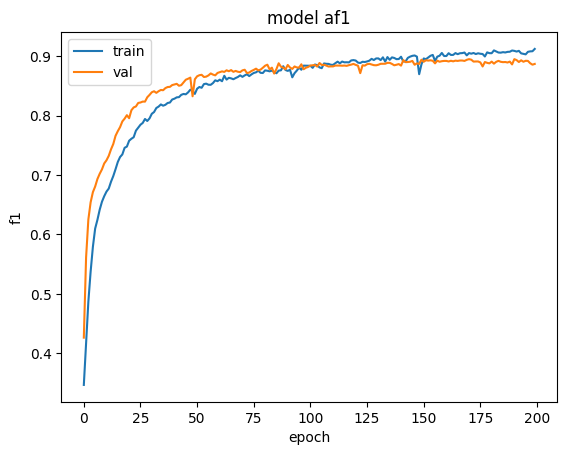

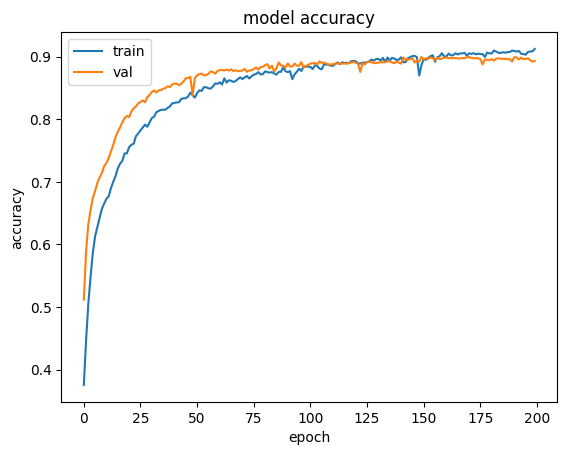

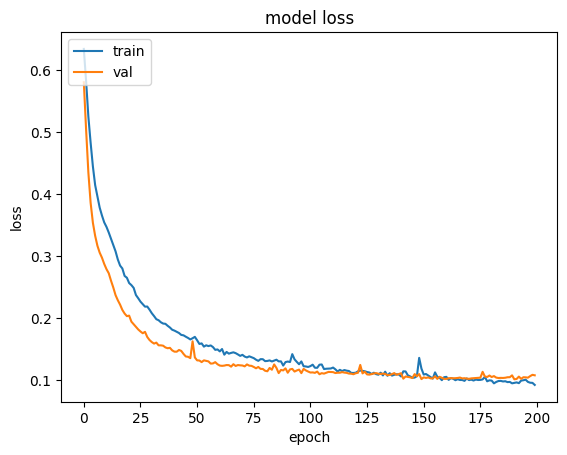

None


In [553]:
print(print_hist(history))

In [556]:
model.evaluate(X_test, y_test, batch_size=256)

21/21 [==============================] - 0s 7ms/step - loss: 0.1093 - accuracy: 0.8908 - f1: 0.8914


[0.10931409150362015, 0.8908001780509949, 0.8914240598678589]

In [558]:
predict = model.predict(X_test)
encode_predict = np.argmax(predict, axis=1)
label_predict = l_encode.inverse_transform(encode_predict)
i = 0
for encode, label in zip(encode_predict, label_predict):
    if i <= 10:
        print(encode, label)
        i += 1
    else:
        break

162/162 [==============================] - 1s 7ms/step
0 negative
2 positive
1 neutral
2 positive
1 neutral
0 negative
2 positive
1 neutral
2 positive
1 neutral
0 negative


In [559]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
cm

162/162 [==============================] - 1s 7ms/step


array([[1517,   58,  133],
       [  96, 1524,   64],
       [ 170,   44, 1568]])

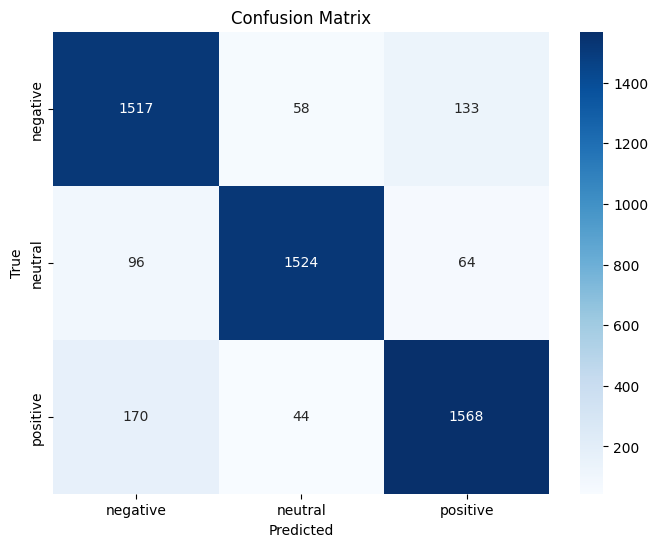

In [560]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [561]:
from sklearn.metrics import classification_report
y_pred = model.predict(X_test)
report = classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
print(report)

162/162 [==============================] - 1s 7ms/step
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1708
           1       0.94      0.90      0.92      1684
           2       0.89      0.88      0.88      1782

    accuracy                           0.89      5174
   macro avg       0.89      0.89      0.89      5174
weighted avg       0.89      0.89      0.89      5174



In [562]:
model.save('balanced_vader_model_best_256.keras')
model.save('balanced_vader_model_best_256.h5')

/home/g6401201087/Python/myvenv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
